# DeepDream

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image
import pathlib
import os
import sys

In [3]:
# Images utility functions
path_to_modules = '/content/drive/MyDrive/Projects/Deep Dream'
sys.path.append(path_to_modules)
from images_aux import *

## Initialize file paths

In [4]:
# Paths to data
data_url = path_to_modules+'/example_images'
data_dir = pathlib.Path(data_url)

save_url = path_to_modules+'/created_images'

# Lets see our number of samples
train_image_count = len(list(data_dir.glob('*.*')))
print("Items in directory:",train_image_count)

# Check for corrupted files
good_urls, bad_urls = get_corrupted_files(data_dir, verbose=2, ret_split=1)

Items in directory: 20
Checked: 20, verified: 20, corrupted: 0


## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [5]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [6]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [7]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [8]:
def run_deep_dream_with_octaves(img, steps_per_octave=20, step_size=0.01, 
                                octaves=range(-3,3), octave_scale=1.2):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  #img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show_np_img(deprocess(img), use_pil=True)
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

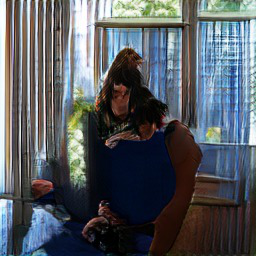

In [12]:
original_img = img_to_np(good_urls[18],max_dim=800)
show_np_img(original_img, use_pil=True)

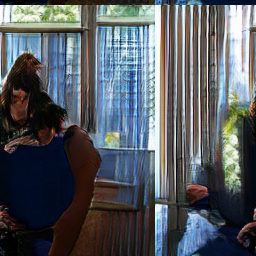

In [13]:
shift, img_rolled = random_roll(np.array(original_img), 1200)
show_np_img(img_rolled, use_pil=True)

In [14]:
def get_usable_layers(model):
  """
  Returns a list of all the usuable layers that we can feed as outputs for our model, 
  together with the list of names
  """
  usable_layers = []
  layer_names = []

  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Concatenate):
      usable_layers.append(layer)
      layer_names.append(layer.name)
  return usable_layers, layer_names

In [18]:
# Maximize the activations of these layers
#base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')

layers, names = get_usable_layers(base_model)
layer_outputs = [layer.output for layer in layers]
layer_outputs = layer_outputs[:6]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layer_outputs)
get_tiled_gradients = TiledGradients(dream_model)

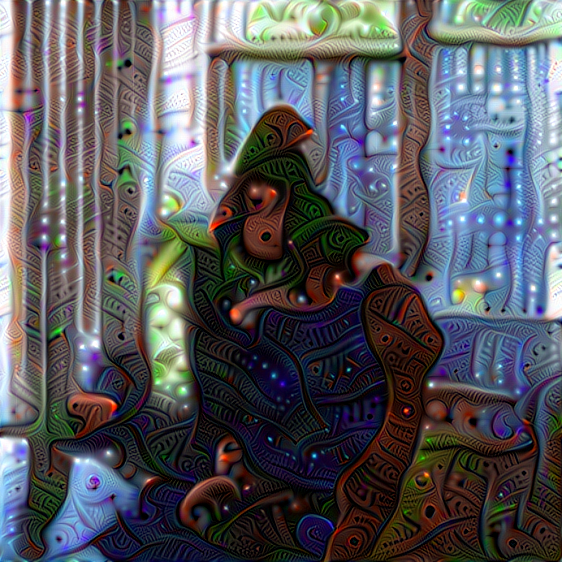

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, steps_per_octave=80, step_size=0.005, 
                                octaves=range(-5,4), octave_scale=1.2)

display.clear_output(wait=True)
#img = tf.image.resize(img, base_shape)
#img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show_np_img(img,use_pil=True)